In [7]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error

In [2]:
# importing the data (both training and validation datasets)
train_df=pd.read_csv(r"C:\Users\tahmi\OneDrive - University of Toledo\SQL_learning\BootCamp_Nov2024\bluebook-for-bulldozers\Train.csv",
                    parse_dates=['saledate'],
                    low_memory=False).sort_values(by='saledate', ascending=True)
valid_df=pd.read_csv(r"C:\Users\tahmi\OneDrive - University of Toledo\SQL_learning\BootCamp_Nov2024\bluebook-for-bulldozers\Valid.csv",
                    parse_dates=['saledate'])
valid_solution=pd.read_csv(r"C:\Users\tahmi\OneDrive - University of Toledo\SQL_learning\BootCamp_Nov2024\bluebook-for-bulldozers\ValidSolution.csv")

valid_df['SalePrice']=valid_df['SalesID'].map(valid_solution.set_index('SalesID')['SalePrice'])
valid_df=valid_df.sort_values(by='saledate', ascending=True).reset_index(drop=True)

In [3]:
# add datetime features

def add_datetime_features_to_df(df, date_column='saledate'):
    df=df.copy()
    df['saleYear']= df[date_column].dt.year
    df['saleMonth']=df[date_column].dt.month
    df['saleDay']=df[date_column].dt.day
    df['saleDayofweek']=df[date_column].dt.dayofweek
    df['saleDayofyear']=df[date_column].dt.dayofyear
    return df.drop(date_column, axis=1)

# apply datetime features
train_df=add_datetime_features_to_df(train_df)
valid_df=add_datetime_features_to_df(valid_df)


In [4]:
# Split data into X and y
X_train=train_df.drop('SalePrice', axis=1)
y_train=train_df['SalePrice']

X_valid=valid_df.drop('SalePrice', axis=1)
y_valid=valid_df['SalePrice']

In [5]:
# Define numeric and categorical features

numeric_features= [label for label, content in X_train.items()
                  if pd.api.types.is_numeric_dtype(content)]
categorical_features=[label for label, content in X_train.items()
                     if not pd.api.types.is_numeric_dtype(content)]

In [8]:
### Filling missing values ### 

# Create an ordinal encoder (turns category items into numeric representation)
ordinal_encoder = OrdinalEncoder(categories="auto",
                                 handle_unknown="use_encoded_value",
                                 unknown_value=np.nan,
                                 encoded_missing_value=np.nan) # treat unknown categories as np.nan (or None)

# Create a simple imputer to fill missing values with median
simple_imputer_median = SimpleImputer(missing_values=np.nan,
                                      strategy="median")


In [10]:
# Fit and transform the categorical and numerical columns of X_train
X_train_preprocessed = X_train.copy() # make copies of the oringal DataFrames so we can keep the original values in tact and view them later
X_train_preprocessed[categorical_features] = ordinal_encoder.fit_transform(X_train_preprocessed[categorical_features].astype(str)) # OrdinalEncoder expects all values as the same type (e.g. string or numeric only)
X_train_preprocessed[numeric_features] = simple_imputer_median.fit_transform(X_train_preprocessed[numeric_features])

# Transform the categorical and numerical columns of X_valid 
X_valid_preprocessed = X_valid.copy()
X_valid_preprocessed[categorical_features] = ordinal_encoder.transform(X_valid_preprocessed[categorical_features].astype(str)) # only use `transform` on the validation data
X_valid_preprocessed[numeric_features] = simple_imputer_median.transform(X_valid_preprocessed[numeric_features])


In [11]:
# Create function to evaluate our model
def show_scores(model, 
                train_features=X_train_preprocessed,
                train_labels=y_train,
                valid_features=X_valid_preprocessed,
                valid_labels=y_valid):
    
    # Make predictions on train and validation features
    train_preds = model.predict(X=train_features)
    val_preds = model.predict(X=valid_features)

    # Create a scores dictionary of different evaluation metrics
    scores = {"Training MAE": mean_absolute_error(y_true=train_labels, 
                                                  y_pred=train_preds),
              "Valid MAE": mean_absolute_error(y_true=valid_labels, 
                                               y_pred=val_preds),
              "Training RMSLE": root_mean_squared_log_error(y_true=train_labels, 
                                                            y_pred=train_preds),
              "Valid RMSLE": root_mean_squared_log_error(y_true=valid_labels, 
                                                         y_pred=val_preds),
              "Training R^2": model.score(X=train_features, 
                                          y=train_labels),
              "Valid R^2": model.score(X=valid_features, 
                                       y=valid_labels)}
    return scores

In [12]:
%%time

# Instantiate a model with best hyperparameters 
model = RandomForestRegressor(n_jobs=-1)
                                      

# Fit a model to the preprocessed data
model.fit(X=X_train_preprocessed, 
                  y=y_train)

# Evalute the model
model_scores = show_scores(model=model)
model_scores

{'Training MAE': 1586.8889562854472,
 'Valid MAE': 6172.541864685043,
 'Training RMSLE': 0.0850234881759053,
 'Valid RMSLE': 0.25821989721068817,
 'Training R^2': 0.9873959310158019,
 'Valid R^2': 0.8707204208161534}

In [20]:
%%time

from sklearn.model_selection import RandomizedSearchCV

# 1. Define a dictionary with different values for RandomForestRegressor hyperparameters
rf_grid={
    'n_estimators': np.arange(10, 200, 10),
    'max_depth':[None, 10,20],
    'min_samples_split':np.arange(2,10,1),
    'min_samples_leaf':np.arange(1,10,1),
    'max_features': [0.5,1,'sqrt'],
    'max_samples':[10000]
}

# 2. Setup instance of RandomizedSearchCV to explore different parameters
rs_model=RandomizedSearchCV(estimator= RandomForestRegressor(),
                           param_distributions=rf_grid,
                           n_iter=10,
                           cv=3,
                           verbose=2)
                           
# 3. Fit the model using a series of different hyperparameter values
rs_model.fit(X_train_preprocessed, y_train)

# Display the best parameters
rs_model.best_params_
print(f" Best parameters: {rs_model.best_params_}")

# Evaluate the best pipeline on training and validation data
rs_model_scores=show_scores(rs_model)

print(f'Tuned model scores: {rs_model_scores}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=None, max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=120; total time=  26.9s
[CV] END max_depth=None, max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=120; total time=  29.7s
[CV] END max_depth=None, max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=120; total time=  27.3s
[CV] END max_depth=20, max_features=1, max_samples=10000, min_samples_leaf=4, min_samples_split=9, n_estimators=140; total time=   5.8s
[CV] END max_depth=20, max_features=1, max_samples=10000, min_samples_leaf=4, min_samples_split=9, n_estimators=140; total time=   6.1s
[CV] END max_depth=20, max_features=1, max_samples=10000, min_samples_leaf=4, min_samples_split=9, n_estimators=140; total time=   6.3s
[CV] END max_depth=10, max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators

In [22]:
# comparing the models' scores

# 1. add names of models to dictionaries
model_scores['model_name']='default_model'
rs_model_scores['model_name']='random_search_model'

# 2. Turn all model score disctionaries into a list
all_model_scores=[model_scores,
                 rs_model_scores]

# 3. Create DateFrame and sort model scores by validation RMSLE
model_comparison_df=pd.DataFrame(all_model_scores).sort_values(by='Valid RMSLE', ascending=False)
model_comparison_df

,Training MAE,Valid MAE,Training RMSLE,Valid RMSLE,Training R^2,Valid R^2,model_name
1,5780.794627,7201.836025,0.266659,0.298759,0.851423,0.833574,random_search_model
0,1586.888956,6172.541865,0.085023,0.258220,0.987396,0.870720,default_model


([0, 1], [Text(0, 0, 'random_search_model'), Text(1, 0, 'default_model')])

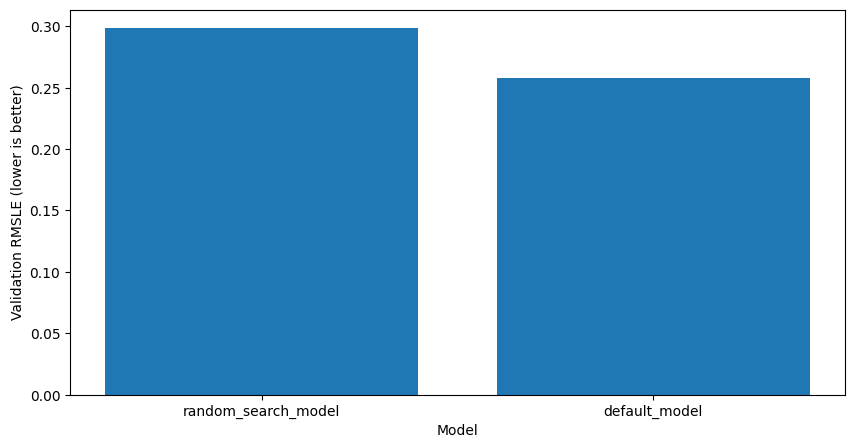

In [25]:
# Plot validation RMSLE vs each other
plt.figure(figsize=(10,5))
plt.bar(model_comparison_df['model_name'],
       model_comparison_df['Valid RMSLE'].values)

plt.xlabel('Model')
plt.ylabel('Validation RMSLE (lower is better)')
plt.xticks(rotation=0, fontsize=10)

In [29]:
# making predictions on test data
test_df= pd.read_csv(r"C:\Users\tahmi\OneDrive - University of Toledo\SQL_learning\BootCamp_Nov2024\bluebook-for-bulldozers\Test.csv",
                    parse_dates=['saledate'])


In [30]:
# Preprocess test_df to have same columns as train_df
test_df=add_datetime_features_to_df(test_df)

In [31]:
# Convert categorical features and fill the missing values
test_df_preprocessed=test_df.copy()
test_df_preprocessed[categorical_features]=ordinal_encoder.transform(test_df_preprocessed[categorical_features].astype(str))
test_df_preprocessed[numeric_features]=simple_imputer_median.transform(test_df_preprocessed[numeric_features])

In [32]:
test_preds=model.predict(test_df_preprocessed)

In [33]:
test_preds.shape, test_df.shape

((12457,), (12457, 56))

In [34]:
# Create DataFrame compatible with Kaggle submission requirements

pred_df=pd.DataFrame()
pred_df['SalesID']=test_df['SalesID']
pred_df['SalePrice']=test_preds
pred_df.sample(10)

,SalesID,SalePrice
3203,6261584,14950.0
6422,6304135,71410.0
3562,6265345,9418.5
6043,6294870,65660.0
10691,6626869,33340.0
10083,6621951,15742.5
10840,6628061,17022.5
19,1227912,39545.0
12192,6637969,14092.5
5897,6289967,11033.0


In [35]:
# find feature importance of the model

model_feature_importance=model.feature_importances_
model_feature_importance

array([5.09296617e-02, 1.67527390e-02, 7.37821958e-02, 7.19163407e-04,
       4.67650898e-03, 2.31685353e-01, 3.38443153e-03, 1.14219948e-03,
       2.12248736e-02, 8.21969294e-02, 1.87774153e-02, 3.83275558e-03,
       7.72155754e-03, 2.29944372e-01, 3.76429178e-02, 9.05516517e-03,
       2.13484258e-03, 1.32521634e-03, 1.22388110e-03, 7.93899592e-03,
       4.95619696e-04, 5.25034355e-05, 6.92442518e-03, 1.74199854e-04,
       6.81539836e-04, 6.67640662e-05, 8.74968607e-04, 1.12790250e-03,
       6.15131345e-04, 8.32945957e-04, 1.42690652e-03, 2.23900292e-03,
       4.21400052e-03, 1.29306540e-03, 1.27581700e-03, 2.18708283e-02,
       1.20521268e-03, 3.07382861e-02, 2.55683907e-05, 7.66119915e-06,
       6.58206547e-04, 1.58273048e-03, 1.68496674e-03, 8.55765172e-04,
       6.10578446e-04, 9.34270558e-04, 1.50227643e-04, 1.73158082e-03,
       2.07663780e-03, 1.67641882e-04, 2.00859001e-04, 7.48748959e-02,
       3.42438079e-03, 9.31754477e-03, 4.59543931e-03, 1.49007498e-02])

In [40]:
model_feature_importance.shape[0], test_df.shape[1]

(56, 56)

In [43]:
# create feature importance DataFrame

column_names=test_df.columns
feature_importance_df=pd.DataFrame({'feature_names': column_names,
                                    'feature_importance': model_feature_importance}).sort_values(by='feature_importance',
                                                                                               ascending=False)
feature_importance_df

,feature_names,feature_importance
5,YearMade,0.231685
13,ProductSize,0.229944
9,fiBaseModel,0.082197
51,saleYear,0.074875
2,ModelID,0.073782
0,SalesID,0.050930
14,fiProductClassDesc,0.037643
37,Coupler_System,0.030738
35,Tire_Size,0.021871
8,fiModelDesc,0.021225


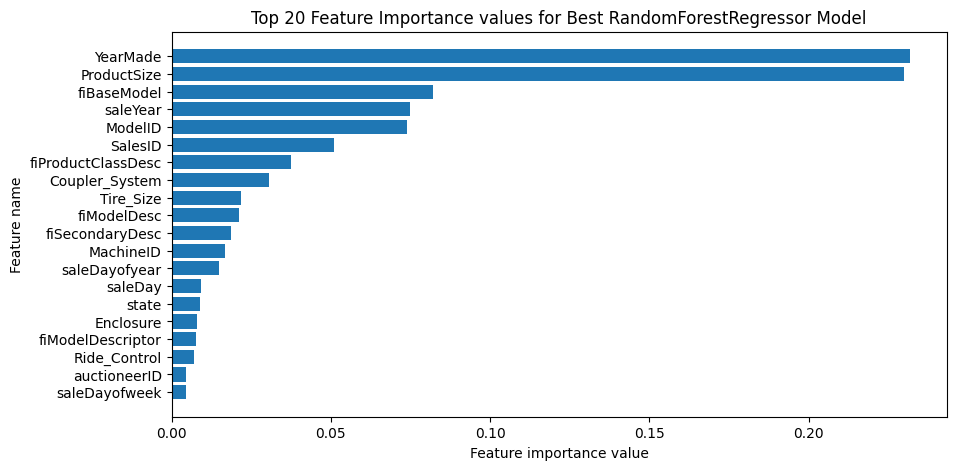

In [48]:
# Plot the top feature importace values

top_n=20
plt.figure(figsize=(10,5))
plt.barh(feature_importance_df['feature_names'][:top_n],
         feature_importance_df['feature_importance'][:top_n])
plt.title(f'Top {top_n} Feature Importance values for Best RandomForestRegressor Model')
plt.xlabel('Feature importance value')
plt.ylabel('Feature name')
plt.gca().invert_yaxis()